In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Specify working directory.
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

# Ensure that the Python interpreter of the Colab VM can load python files from
# within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive
/content/drive/My Drive/cs231n/project


## Create videos dataframe
Download 
BII Sneeze-Cough Human Action Video Dataset at https://web.bii.a-star.edu.sg/~chengli/FluRecognition/videos/biisc.zip, unzip it, and save the `videos` folder under directory `cs231n/project/dataset/videos`.

Video File Naming Convention:

\{subject id: 4 char\}_{gender: 1 char}_\{action: 4 char\}_\{stand or walk: 3 char\}_\{pose: 3 char\}[_HF].avi


In [2]:
import os
import pandas as pd

video_path = 'dataset/videos/'
videos = os.listdir(video_path)
subjects = []
actions =[]

for vid in videos:
  # Read index.
  subjects.append(vid[:4])
  # Read actions
  actions.append(vid.split('_')[2])

# Convert actions to 1 = flu sym, 0 = no flu sym.
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 0,
    'SCRA': 0,
    'SNEE': 1,
    'STRE': 0,
    'WAVE': 0,
    'WIPE': 0,
}
labels = [mapping[x] for x in actions]    

df_videos = pd.DataFrame({
    'video_subject': subjects,
    'video_name': videos,
    'action': actions,
    'label': labels
    
})

# Shuffle df_videos.
df_videos = df_videos.sample(frac=1, random_state=42).reset_index(drop=True)


df_videos.head()

,video_subject,video_name,action,label
0,S018,S018_M_CALL_STD_LFT_HF.avi,CALL,0
1,S017,S017_F_COUG_WLK_RGT.avi,COUG,1
2,S006,S006_M_SCRA_STD_FCE.avi,SCRA,0
3,S015,S015_M_WAVE_WLK_FCE_HF.avi,WAVE,0
4,S005,S005_M_WIPE_WLK_FCE.avi,WIPE,0


## Create Train/Test datasets

From the paper authors: "In our current experiments, the videos from subjects S002, S003, S004, S005, S006 are used for testing and the rest are used for training."

In [3]:
df_videos_train = df_videos.loc[~df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
df_videos_test  = df_videos.loc[df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
print(df_videos_train.groupby('label').count())
print(df_videos_test.groupby('label').count())

       index  video_subject  video_name  action
label                                          
0       1080           1080        1080    1080
1        360            360         360     360
       index  video_subject  video_name  action
label                                          
0        360            360         360     360
1        120            120         120     120


## Create folders for Train & Test frames

In [4]:
frames_path = 'dataset/frames/'
train_frames_path = os.path.join(frames_path, 'train')
test_frames_path = os.path.join(frames_path, 'test')
try:
    os.mkdir(frames_path)
except FileExistsError as ae:
    print('dataset/frames already created')
try:
    os.mkdir(train_frames_path)
except FileExistsError as ae:
    print('dataset/frames/train already created')
try:
    os.mkdir(test_frames_path)
except FileExistsError as ae:
    print('dataset/frames/test already created')

dataset/frames already created
dataset/frames/train already created
dataset/frames/test already created


### Extract frames from videos

We extract two frames from each second of the video and save the frames as images.

In [ ]:
# Read the video files, extract frames from each corresponding video and put
# them in the corresponding train/test folder.
import cv2

def extract_frames(df, folder_name):
    for _, row in df.iterrows():
        _, video_subject, video_name, action, label = row
        video_read_path = os.path.join(video_path, video_name)
        try:
          os.mkdir(os.path.join(os.path.join(frames_path, folder_name),
                                video_name.split(".")[0]))
          
          train_write_file=os.path.join(os.path.join(frames_path, folder_name),
                                    video_name.split(".")[0])
          cap=cv2.VideoCapture(video_read_path)
          cap.set(cv2.CAP_PROP_FPS, 20)
          frame_rate=int(cap.get(5))
          
          count=0
          while(cap.isOpened()):
              frame_id = cap.get(1)
              ret, frame = cap.read()
              if (ret != True):
                  break
              # Extract 2 frames from each second.
              if (2 * frame_id % frame_rate == 0):
                  filename ="frame%d.jpg" % count; count+=1
                  #frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                  cv2.imwrite(os.path.join(train_write_file,filename), frame)
          cap.release()
        except:
            pass

    return print("All frames written in the "+folder_name+" folder")

extract_frames(df_videos_train, 'train')
extract_frames(df_videos_test, 'test')

All frames written in the train folder
All frames written in the test folder


In [ ]:
# See how many frames are captured for each video.
train_path='/content/drive/My Drive/cs231n/project/dataset/frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/frames/test/'

vid_file_name=df_videos_train.video_name[0].split('.')[0]

train_frames=[]
for i in range(len(df_videos_train.video_name)):
    vid_file_name=df_videos_train.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_path, vid_file_name))))

test_frames=[]
for i in range(len(df_videos_test.video_name)):
    vid_file_name=df_videos_test.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_path,vid_file_name))))

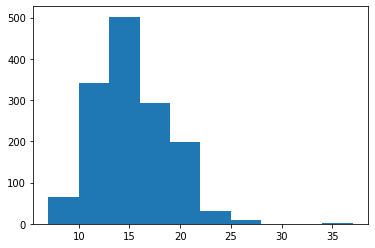

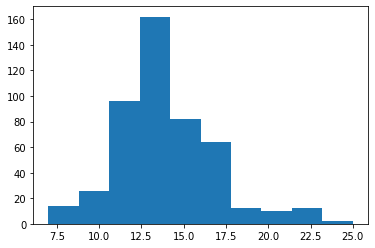

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_frames)
plt.show()

plt.hist(test_frames)
plt.show()


## Making sure that each video has at least x frames

Some videos are short and the frames captured from them are less than x. We will generate extra frames by creating copies of the last frame and put them at the end. This is to make sure that we have at least x frames in each video.

In [ ]:
import shutil

# ad-hoc fix
def fix_frames(dataset, dir_path):
    fill_to_len = 16
    for i in range(len(dataset.video_name)):
        print(i)
        vid_name = dataset.video_name[i]
        vid_path = os.path.join(dir_path, vid_name.split(".")[0])
        list_frames = []
        for x in os.listdir(vid_path):
            cur = int(x[5] if len(x) == 10 else x[5:7])
            if 1 <= cur <= 90:
                list_frames.append(x)
            else:
                os.remove(os.path.join(vid_path, x))
        list_frames = sorted([list_frames])
        c = 0
        countu=91
        for k in range(fill_to_len-len(list_frames)):
            list_frames=os.listdir(vid_path)
            frame=os.path.join(vid_path, list_frames[c])
            new_frame="frame%d.jpg" % countu
            shutil.copy2(frame,os.path.join(vid_path,new_frame))
            countu+=1
            c+=1
    return print("Frame Generation Done!")
    
train_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/test/'

fix_frames(df_videos_train, train_path)
fix_frames(df_videos_test, test_path)

In [ ]:
import shutil

def extend_frames(dataset, dir_path):
    x = 16
    for i in range(len(dataset.video_name)):
        print(i)
        vid_name = dataset.video_name[i]
        vid_name = 'S001_M_SNEE_STD_RGT_HF.avi'
        vid_path = os.path.join(dir_path,vid_name.split(".")[0])
        len_frame = len(os.listdir(vid_path))
        j = x - len(os.listdir(vid_path))
        if j > 0:
            list_frames = os.listdir(vid_path)
            c = 0
            countu=91
            for k in range(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path, list_frames[c])
                new_frame="frame%d.jpg" % countu
                #shutil.copy2(frame,os.path.join(vid_path,new_frame))
                countu+=1
                c+=1
            break
        else:
            break
            pass
    return print("Frame Generation Done!")
    
train_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/test/'

extend_frames(df_videos_train, train_path)
extend_frames(df_videos_test, test_path)

## Split training and validation datasets

In [5]:
train_ratio = 0.70

label_1_dat = df_videos_train.loc[df_videos_train["label"]==1,]
label_0_dat = df_videos_train.loc[df_videos_train["label"]==0,]

train_len_label1 = int(len(label_1_dat)*train_ratio)
train_len_label0 = int(len(label_0_dat)*train_ratio)

train_dat_label1 = label_1_dat.iloc[:train_len_label1,]
train_dat_label0 = label_0_dat.iloc[:train_len_label0,]

val_dat_label1 = label_1_dat.iloc[train_len_label1:,]
val_dat_label0 = label_0_dat.iloc[train_len_label0:,]

train_dat = train_dat_label1.append(train_dat_label0, ignore_index=True)
val_dat = val_dat_label1.append(val_dat_label0, ignore_index=True)

In [6]:
print(train_dat.groupby('action')['index'].count())
print(val_dat.groupby('action')['index'].count())

action
CALL    123
COUG    119
DRIN    133
SCRA    117
SNEE    132
STRE    127
WAVE    125
WIPE    131
Name: index, dtype: int64
action
CALL    57
COUG    61
DRIN    47
SCRA    63
SNEE    48
STRE    53
WAVE    55
WIPE    49
Name: index, dtype: int64


## Create input for model

Function below extracts the first x frames for each video, resize each frame into (224,224) image and add paddings if videos are too short.

In [7]:
from PIL import Image
import numpy as np

def create_frame_dataset(dataset, input_path, output_path):
    x = 12
    frames = []
    for i in np.arange(len(dataset)):
        if i % 10 == 0: print(f'Progress: {i} / {len(dataset)}')
        vid_name = dataset.video_name[i].split(".")[0]
        vid_dir_path = os.path.join(input_path, vid_name)
        frames_to_select = []
        list_frames = sorted(os.listdir(vid_dir_path))
        vid_data=[]
        for frame in list_frames:
            cur = int(frame[5:len(frame)-4])
            # only take first occurence
            if cur > 90: continue
            image = Image.open(os.path.join(vid_dir_path,frame))
            datu = np.asarray(image)
            if len(datu.shape) != 3: continue
            normu_dat = datu/255
            vid_data.append(normu_dat)
            if len(vid_data) >= x: break
        vid_data = np.array(vid_data)
        if len(vid_data) < x:
            # pre-pad special value for masking lstm later
            special_value = 0.0
            vid_data = np.pad(vid_data, ((x-len(vid_data),0),(0,0),(0,0),(0,0)),
                              mode='constant', constant_values=special_value)
        print(i, vid_data.shape)
        frames.append(vid_data)
    dataset_new = np.array(frames)
    print(dataset_new.shape)
    dataset_new = dataset_new.reshape((dataset_new.shape[0],x,224,224,3))
    labels = np.array(dataset.label)
    actions = np.array(dataset.action)
    return dataset_new, labels, actions

In [8]:
# Output directory.
output_path = "/content/drive/My Drive/cs231n/project/dataset/shaped_cropped_data/"

# Save final dataset.
try:
    os.mkdir(output_path)
except FileExistsError:
    pass

In [14]:
# Training dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
dataset_new, labels, actions = create_frame_dataset(train_dat, input_path, output_path)
np.save(os.path.join(output_path, "train_data_pre12"), dataset_new)
np.save(os.path.join(output_path, "train_labels_pre12"), labels)
np.save(os.path.join(output_path, "train_actions_pre12"), actions)

Progress: 0 / 1007
Progress: 10 / 1007
Progress: 20 / 1007
Progress: 30 / 1007
Progress: 40 / 1007
Progress: 50 / 1007
Progress: 60 / 1007
Progress: 70 / 1007
Progress: 80 / 1007
Progress: 90 / 1007
Progress: 100 / 1007
Progress: 110 / 1007
Progress: 120 / 1007
Progress: 130 / 1007
Progress: 140 / 1007
Progress: 150 / 1007
Progress: 160 / 1007
Progress: 170 / 1007
Progress: 180 / 1007
Progress: 190 / 1007
Progress: 200 / 1007
Progress: 210 / 1007
Progress: 220 / 1007
Progress: 230 / 1007
Progress: 240 / 1007
Progress: 250 / 1007
Progress: 260 / 1007
Progress: 270 / 1007
Progress: 280 / 1007
Progress: 290 / 1007
Progress: 300 / 1007
Progress: 310 / 1007
Progress: 320 / 1007
Progress: 330 / 1007
Progress: 340 / 1007
Progress: 350 / 1007
Progress: 360 / 1007
Progress: 370 / 1007
Progress: 380 / 1007
Progress: 390 / 1007
Progress: 400 / 1007
Progress: 410 / 1007
Progress: 420 / 1007
Progress: 430 / 1007
Progress: 440 / 1007
Progress: 450 / 1007
Progress: 460 / 1007
Progress: 470 / 1007
Pro

In [15]:
# Validation dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/train/'
dataset_new, labels, actions = create_frame_dataset(val_dat, input_path, output_path)
np.save(os.path.join(output_path, "val_data_pre12"), dataset_new)
np.save(os.path.join(output_path, "val_labels_pre12"), labels)
np.save(os.path.join(output_path, "val_actions_pre12"), actions)

Progress: 0 / 433
Progress: 10 / 433
Progress: 20 / 433
Progress: 30 / 433
Progress: 40 / 433
Progress: 50 / 433
Progress: 60 / 433
Progress: 70 / 433
Progress: 80 / 433
Progress: 90 / 433
Progress: 100 / 433
Progress: 110 / 433
Progress: 120 / 433
Progress: 130 / 433
Progress: 140 / 433
Progress: 150 / 433
Progress: 160 / 433
Progress: 170 / 433
Progress: 180 / 433
Progress: 190 / 433
Progress: 200 / 433
Progress: 210 / 433
Progress: 220 / 433
Progress: 230 / 433
Progress: 240 / 433
Progress: 250 / 433
Progress: 260 / 433
Progress: 270 / 433
Progress: 280 / 433
Progress: 290 / 433
Progress: 300 / 433
Progress: 310 / 433
Progress: 320 / 433
Progress: 330 / 433
Progress: 340 / 433
Progress: 350 / 433
Progress: 360 / 433
Progress: 370 / 433
Progress: 380 / 433
Progress: 390 / 433
Progress: 400 / 433
Progress: 410 / 433
Progress: 420 / 433
Progress: 430 / 433


In [10]:
# Test dataset.
input_path='/content/drive/My Drive/cs231n/project/dataset/cropped_frames/test/'
dataset_new, labels, actions = create_frame_dataset(df_videos_test, input_path, output_path)
np.save(os.path.join(output_path, "test_data_pre12"), dataset_new)
np.save(os.path.join(output_path, "test_labels_pre12"), labels)
np.save(os.path.join(output_path, "test_actions_pre12"), actions)

Progress: 0 / 480
0 (12, 224, 224, 3)
1 (12, 224, 224, 3)
2 (12, 224, 224, 3)
3 (12, 224, 224, 3)
4 (12, 224, 224, 3)
5 (12, 224, 224, 3)
6 (12, 224, 224, 3)
7 (12, 224, 224, 3)
8 (12, 224, 224, 3)
9 (12, 224, 224, 3)
Progress: 10 / 480
10 (12, 224, 224, 3)
11 (12, 224, 224, 3)
12 (12, 224, 224, 3)
13 (12, 224, 224, 3)
14 (12, 224, 224, 3)
15 (12, 224, 224, 3)
16 (12, 224, 224, 3)
17 (12, 224, 224, 3)
18 (12, 224, 224, 3)
19 (12, 224, 224, 3)
Progress: 20 / 480
20 (12, 224, 224, 3)
21 (12, 224, 224, 3)
22 (12, 224, 224, 3)
23 (12, 224, 224, 3)
24 (12, 224, 224, 3)
25 (12, 224, 224, 3)
26 (12, 224, 224, 3)
27 (12, 224, 224, 3)
28 (12, 224, 224, 3)
29 (12, 224, 224, 3)
Progress: 30 / 480
30 (12, 224, 224, 3)
31 (12, 224, 224, 3)
32 (12, 224, 224, 3)
33 (12, 224, 224, 3)
34 (12, 224, 224, 3)
35 (12, 224, 224, 3)
36 (12, 224, 224, 3)
37 (12, 224, 224, 3)
38 (12, 224, 224, 3)
39 (12, 224, 224, 3)
Progress: 40 / 480
40 (12, 224, 224, 3)
41 (12, 224, 224, 3)
42 (12, 224, 224, 3)
43 (12, 224, 

In [ ]:
# To load dataset:
#  train_data = np.load('/content/drive/My Drive/cs231n/project/dataset/shaped_data/train_data.npy')
# train_labels = np.load('/content/drive/My Drive/cs231n/project/dataset/shaped_data/train_labels.npy')